# Vehicle Detection and Tracking

This project consists of detection and tracking vehicles in images and video.
For this, some of the steps are:
- extract image features
- search for cars in images implementing a sliding window algorithm
- train a machine learning classifier (SVM, decision tree, neural network, etc.)
- evaluate the results checking for false positives and false negatives


Features could be:
- raw color intensity (pixel value => Template matching)
- histogram of pixel intensity
- gradients of pixel intensity
- saturation channel (change color spaces)
- histogram of oriented gradients (HOG)

https://en.wikipedia.org/wiki/Feature_vector

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import glob
import time
import pickle
import warnings

%matplotlib inline
#%matplotlib qt

In [2]:
def inspect_data(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example.shape
    data_dict["data_type"] = example.dtype
    return data_dict

In [3]:
def convert_color(img, conv='HLS'):
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

In [4]:
# draws boxes or circles on image/frame
def draw_emphasis(img, bboxes, color=(0, 0, 255), thick=6, form='box'):
    # make a copy of the image
    draw_img = np.copy(img)
    if form == 'box':
        # draw each bounding box on your image copy using cv2.rectangle()
        for box in bboxes:
            #
            cv2.rectangle(draw_img, box[0], box[1], color, thick)
    elif form == 'circle':
        cv2.circle(draw_img, ((box[0][0] + box[1][0])/2, (box[0][1] + box[1][1])/2), (box[1][0] - box[0][0])/2, color, thick)
    
    # return the image copy with boxes drawn
    return draw_img

In [5]:
#
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/9acf11c2-a5a9-4e5a-ba86-1e92246fff99
#
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
    
    # Return the list of bounding boxes
    bbox_list

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist, bin_edges = np.histogram(img[:,:,0], bins=nbins, range=bins_range, density=True)
    rhist = rhist * np.diff(bin_edges)
    
    ghist, bin_edges = np.histogram(img[:,:,1], bins=nbins, range=bins_range, density=True)
    ghist = ghist * np.diff(bin_edges)
    
    bhist, bin_edges = np.histogram(img[:,:,2], bins=nbins, range=bins_range, density=True)
    bhist = bhist * np.diff(bin_edges)
    
    # Concatenate the histograms into a single feature vector
    #hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    hist_features = np.concatenate((rhist, ghist, bhist))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [10]:
# return a resize image converted to some colorspace as a feature vector
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # 
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)      
    
    features = cv2.resize(img, size).ravel()
    #img = cv2.resize(feature_image, size)
    
    #features = img.ravel().astype(np.float64)  # ravel == reshape
    
    if np.amax(features) > 1:
        features = features * 1. / 255

    # Return the feature vector
    return features

In [11]:
# apply skimage hog function and returns feature vector
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [12]:
# Define a function to extract features from a list of images
# Takes in list of files, convert color, resize, calculate histogram, extract hog, 
# Have this function call bin_spatial() and color_hist()
def extract_train_features(imgs, 
                           cspace='RGB', 
                           orient=9,
                           pix_per_cell=8, 
                           cell_per_block=2, 
                           spatial_size=(32, 32),
                           hist_bins=32, 
                           hist_range=(0, 256), 
                           hog_channel=0):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    i = 0
    for file in imgs:
        i += 1
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        #image = image * 255
        #image = image.astype(np.uint8)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)      
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # resize image
        #feature_image = cv2.resize(feature_image, spatial_size)
        
        i_s = image.shape
        # 
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                #imgrs = cv2.resize(feature_image[:, :, channel], (i_s[0]*1, i_s[1]*1))
                imgrs = feature_image[:, :, channel].copy()
                hog_features.append(get_hog_features(imgrs, 
                                                     orient, 
                                                     pix_per_cell, 
                                                     cell_per_block, 
                                                     vis=False, 
                                                     feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], 
                                            orient, 
                                            pix_per_cell, 
                                            cell_per_block, 
                                            vis=False, 
                                            feature_vec=True)


        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))

    #a = np.array(spatial_features)
    #b = np.array(hist_features)
    #c = np.array(hog_features)
    #print('   spatial', a.shape, a.dtype)
    #print('   histogram', b.shape, b.dtype)
    #print('   hog', c.shape, c.dtype)
    
    # Return list of feature vectors
    return features
    #return np.array(features).astype(np.float64) 

In [14]:
def frame_features():
    pass

In [15]:
def predict_image(img, x, y, X_scaler, model):

    #img_tosearch = img[400:656, :, :3]
    tosearch = convert_color(img[400:656, :, :3], conv='YUV')

    # color channels
    ch1 = tosearch[:, :, 0]
    ch2 = tosearch[:, :, 1]
    ch3 = tosearch[:, :, 2]    
    
    hog1 = get_hog_features(ch1, 9, 8, 2, feature_vec=False)
    hog2 = get_hog_features(ch2, 9, 8, 2, feature_vec=False)
    hog3 = get_hog_features(ch3, 9, 8, 2, feature_vec=False)

    hog_features = np.ravel([hog_feat1, hog_feat2, hog_feat3])

    window = 64
    subimg = tosearch[y:y + window, x:x + window].copy()
    spatial_features = bin_spatial(subimg, size=(32, 32))
    hist_features = color_hist(subimg, nbins=32)
    
    features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)
    test_features = X_scaler.transform(features)    
    test_prediction = model.predict(test_features)
    
    return test_prediction

In [16]:
def predict_window(img, X_scaler, model):
    
    img = cv2.resize(img, (64, 64))

    #img_tosearch = img[400:656, :, :3]
    img = convert_color(img, conv='YUV')

    # color channels
    ch1 = img[:, :, 0]
    ch2 = img[:, :, 1]
    ch3 = img[:, :, 2]    
    
    hog1 = get_hog_features(ch1, 9, 8, 2, feature_vec=False)
    hog2 = get_hog_features(ch2, 9, 8, 2, feature_vec=False)
    hog3 = get_hog_features(ch3, 9, 8, 2, feature_vec=False)

    hog_features = np.ravel([hog1, hog2, hog3])

    spatial_features = bin_spatial(img, size=(16, 16))
    hist_features = color_hist(img, nbins=32)
    
    features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)
    test_features = X_scaler.transform(features)    
    test_prediction = model.predict(test_features)
    
    return test_prediction

In [38]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, i, cs, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, cps, spatial_size, window, hist_bins):
    
    draw_img = np.copy(img)
    
    # convert JPG [0 - 255] to PNG [0.0 - 1.0] scale
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv=cs)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # color channels
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block ** 2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    #window = np.int(64 * scale)
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = cps  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire search region
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    print("="*40)
    print('Find cars: image {:>4d}'.format(i))
    print("="*40)
    print('  pix_per_cell', pix_per_cell)
    print('  cell_per_block', cell_per_block)
    print('  cells_per_step', cells_per_step)
    print('  nxblocks', nxblocks)
    print('  nyblocks', nyblocks)
    print('  nxsteps', nxsteps)
    print('  nysteps', nysteps)
    print('  nblocks_per_window', nblocks_per_window)
    print('  scale', scale)
    print('  window', window)
    print('  cells_per_step', cells_per_step)
    print('  shape', ctrans_tosearch.shape)
    print('  spatial_size', spatial_size)
    print('  histbins', hist_bins)
    
    boxlist = []
    bbox = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            # walk in cells
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            
            # 
            hog_features = np.ravel([hog_feat1, hog_feat2, hog_feat3])

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
            
            #boxlist.append([xleft, ytop, xleft + window, ytop + window])
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #f1 = True if np.isfinite(hog_features).all() else False
            #print('  hog_features', hog_features.shape, hog_features.dtype, f1)
            
            #f2 = True if np.isfinite(spatial_features).all() else False
            #print('  spatial_features', spatial_features.shape, spatial_features.dtype, f2)
            
            #f3 = True if np.isfinite(hist_features).all() else False
            #print('  hist_features', hist_features.shape, hist_features.dtype, f3)

            # Scale features and make a prediction
            features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)
            
            #f = True if np.isfinite(features).all() else False
            #print('  features', features.shape, features.dtype, f)

            test_features = X_scaler.transform(features)    
            test_prediction = svc.predict(test_features)       
            
            #pred2 = predict_window(subimg, X_scaler, svc)
            #if pred2:
            #    print('found ?')
            
            #if f and f1 and f2 and f3:
            #    test_features = X_scaler.transform(features)    
            #    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #    test_prediction = svc.predict(test_features)
            #else:
            #    print('  infinity')
            #    print('  yb', yb, 'xb', xb)
            #    print('  ypos', ypos, 'xpos', xpos)
            #    print('  image shape', ctrans_tosearch.shape)
            #    #plt.figure()
            #    #plt.imshow(subimg)
            #    #return draw_img, boxlist, bbox
            #    test_prediction = 0
            
            
            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            p1 = (xbox_left, ytop_draw + ystart)
            p2 = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            boxlist.append((p1,p2))
            t = 6
            
            #cv2.rectangle(draw_img, (xleft, ytop + ystart), (xleft + window, ytop + window + ystart), (0, 0, 0), 5)
            #cv2.rectangle(draw_img, p1, p2, (255, 255, 255), 2)  # white box
            if test_prediction == 1:
                # blue
                cor = (0, 0, 255)
                cv2.rectangle(draw_img, p1, p2, cor, 3)
                bbox.append((p1,p2))
                print(' found car', xleft, ytop)
            else:
                # green
                cor = (0, 255, 0)
                cv2.rectangle(draw_img, p1, p2, cor, 3) 
    
    print('  features', features.shape)
                
    return draw_img, boxlist, bbox

In [18]:
def find_cars_2():
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    # Compute individual channel HOG features for the entire search region
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    windows = slide_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap)
    
    boxes = []
    
    for w in range(0, len(windows)):

        # Extract HOG for this patch
        hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
        hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
        hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()

        # 
        hog_features = np.ravel([hog_feat1, hog_feat2, hog_feat3])

        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = convert_color(img_tosearch, conv='YUV')

        subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        f1 = True if np.isfinite(hog_features).all() else False
        #print('  hog_features', hog_features.shape, hog_features.dtype, f1)

        f2 = True if np.isfinite(spatial_features).all() else False
        #print('  spatial_features', spatial_features.shape, spatial_features.dtype, f2)

        f3 = True if np.isfinite(hist_features).all() else False
        #print('  hist_features', hist_features.shape, hist_features.dtype, f3)

        # Scale features and make a prediction
        features = np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)

        f = True if np.isfinite(features).all() else False
        #print('  features', features.shape, features.dtype, f)

        if f and f1 and f2 and f3:
            test_features = X_scaler.transform(features)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
        
        xbox_left = np.int(xleft * scale)
        ytop_draw = np.int(ytop * scale)
        win_draw = np.int(window * scale)
        p1 = (xbox_left, ytop_draw + ystart)
        p2 = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
        boxlist.append((p1,p2))
        t = 6
        if test_prediction == 1:
            #cor = (0, 0, 255)
            #cv2.rectangle(draw_img, p1, p2, cor, 3)
            boxes.append((p1,p2))

    return boxes

In [19]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

In [20]:
#heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_boxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        blue = (0, 0, 255)
        cv2.rectangle(img, bbox[0], bbox[1], blue, 6)
    # Return the image
    return img


In [ ]:
# numpy
# np.ravel = np.reshape(-1)
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ravel.html
# 

# CV2
# https://docs.opencv.org/trunk/d4/dc6/tutorial_py_template_matching.html
# 

# scikit-image
# http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog
# 

# scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV


In [ ]:
from car_search import Car

In [ ]:
car = Car()

# Process images

## HOG features

In [21]:
filen = str(np.random.randint(1, 6))
img = mpimg.imread('./test_images/test' + filen + '.jpg')

hist_features = color_hist(img, nbins=32, bins_range=(0, 256))

#plt.figure()
#fig, axs = plt.subplots(1, 3, figsize=(30, 10))
#rint(rhist)
#axs[0].plot(rhist[0])
#axs[1].plot(ghist[0])
#axs[2].plot(bhist[0])

In [22]:
notcarsfiles = glob.glob('non-vehicles/*/*.png')
carsfiles = glob.glob('vehicles/*/*.png')

Image examples:


(-0.5, 63.5, 63.5, -0.5)

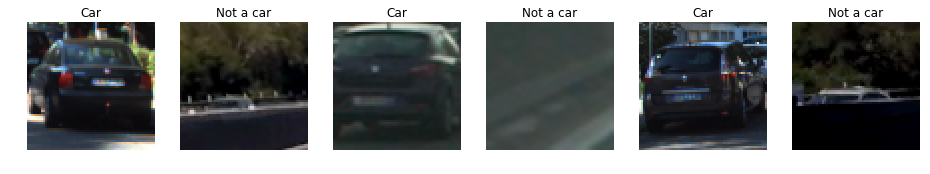

In [23]:

rand_carnot = np.random.randint(0, len(notcarsfiles))
rand_caryes = np.random.randint(0, len(carsfiles))

example_car = mpimg.imread(carsfiles[rand_caryes])
example_not = mpimg.imread(notcarsfiles[rand_carnot])

print('Image examples:')

f = plt.figure();
#plt.axis('off')
fig, axs = plt.subplots(1, 6, figsize=(16, 8));
axs[0].imshow(example_car);
axs[0].set_title('Car');
axs[0].axis('off')
axs[1].imshow(example_not);
axs[1].set_title('Not a car');
axs[1].axis('off')

rand_carnot = np.random.randint(0, len(notcarsfiles))
rand_caryes = np.random.randint(0, len(carsfiles))

example_car = mpimg.imread(carsfiles[rand_caryes])
example_not = mpimg.imread(notcarsfiles[rand_carnot])

axs[2].imshow(example_car);
axs[2].set_title('Car');
axs[2].axis('off')
axs[3].imshow(example_not);
axs[3].set_title('Not a car');
axs[3].axis('off')

rand_carnot = np.random.randint(0, len(notcarsfiles))
rand_caryes = np.random.randint(0, len(carsfiles))

example_car = mpimg.imread(carsfiles[rand_caryes])
example_not = mpimg.imread(notcarsfiles[rand_carnot])

axs[4].imshow(example_car);
axs[4].set_title('Car');
axs[4].axis('off')
axs[5].imshow(example_not);
axs[5].set_title('Not a car');
axs[5].axis('off')

In [24]:
datainsp = inspect_data(carsfiles, notcarsfiles)
for (k, d) in datainsp.items():
    print(k, d)

n_cars 8792
n_notcars 8968
image_shape (64, 64, 3)
data_type float32


In [25]:
carlist = np.array(carsfiles)
notcarlist = np.array(notcarsfiles)
    
# 'not cars' has more samples
if False:
    diff = datainsp['n_notcars'] - datainsp['n_cars']
    print('Difference in length:', diff)

    diffrandidx = np.array(np.random.randint(0, datainsp['n_cars'], size=diff), np.int)

    print('Random indexes')
    print(diffrandidx)
    #print(carlist[diffrandidx])

    # duplicate 'diff' cars
    carlist = np.concatenate((carlist, carlist[diffrandidx]))
    print('New length: ', len(carlist))

Text(0.5,1,'HOG for V channel in YUV')

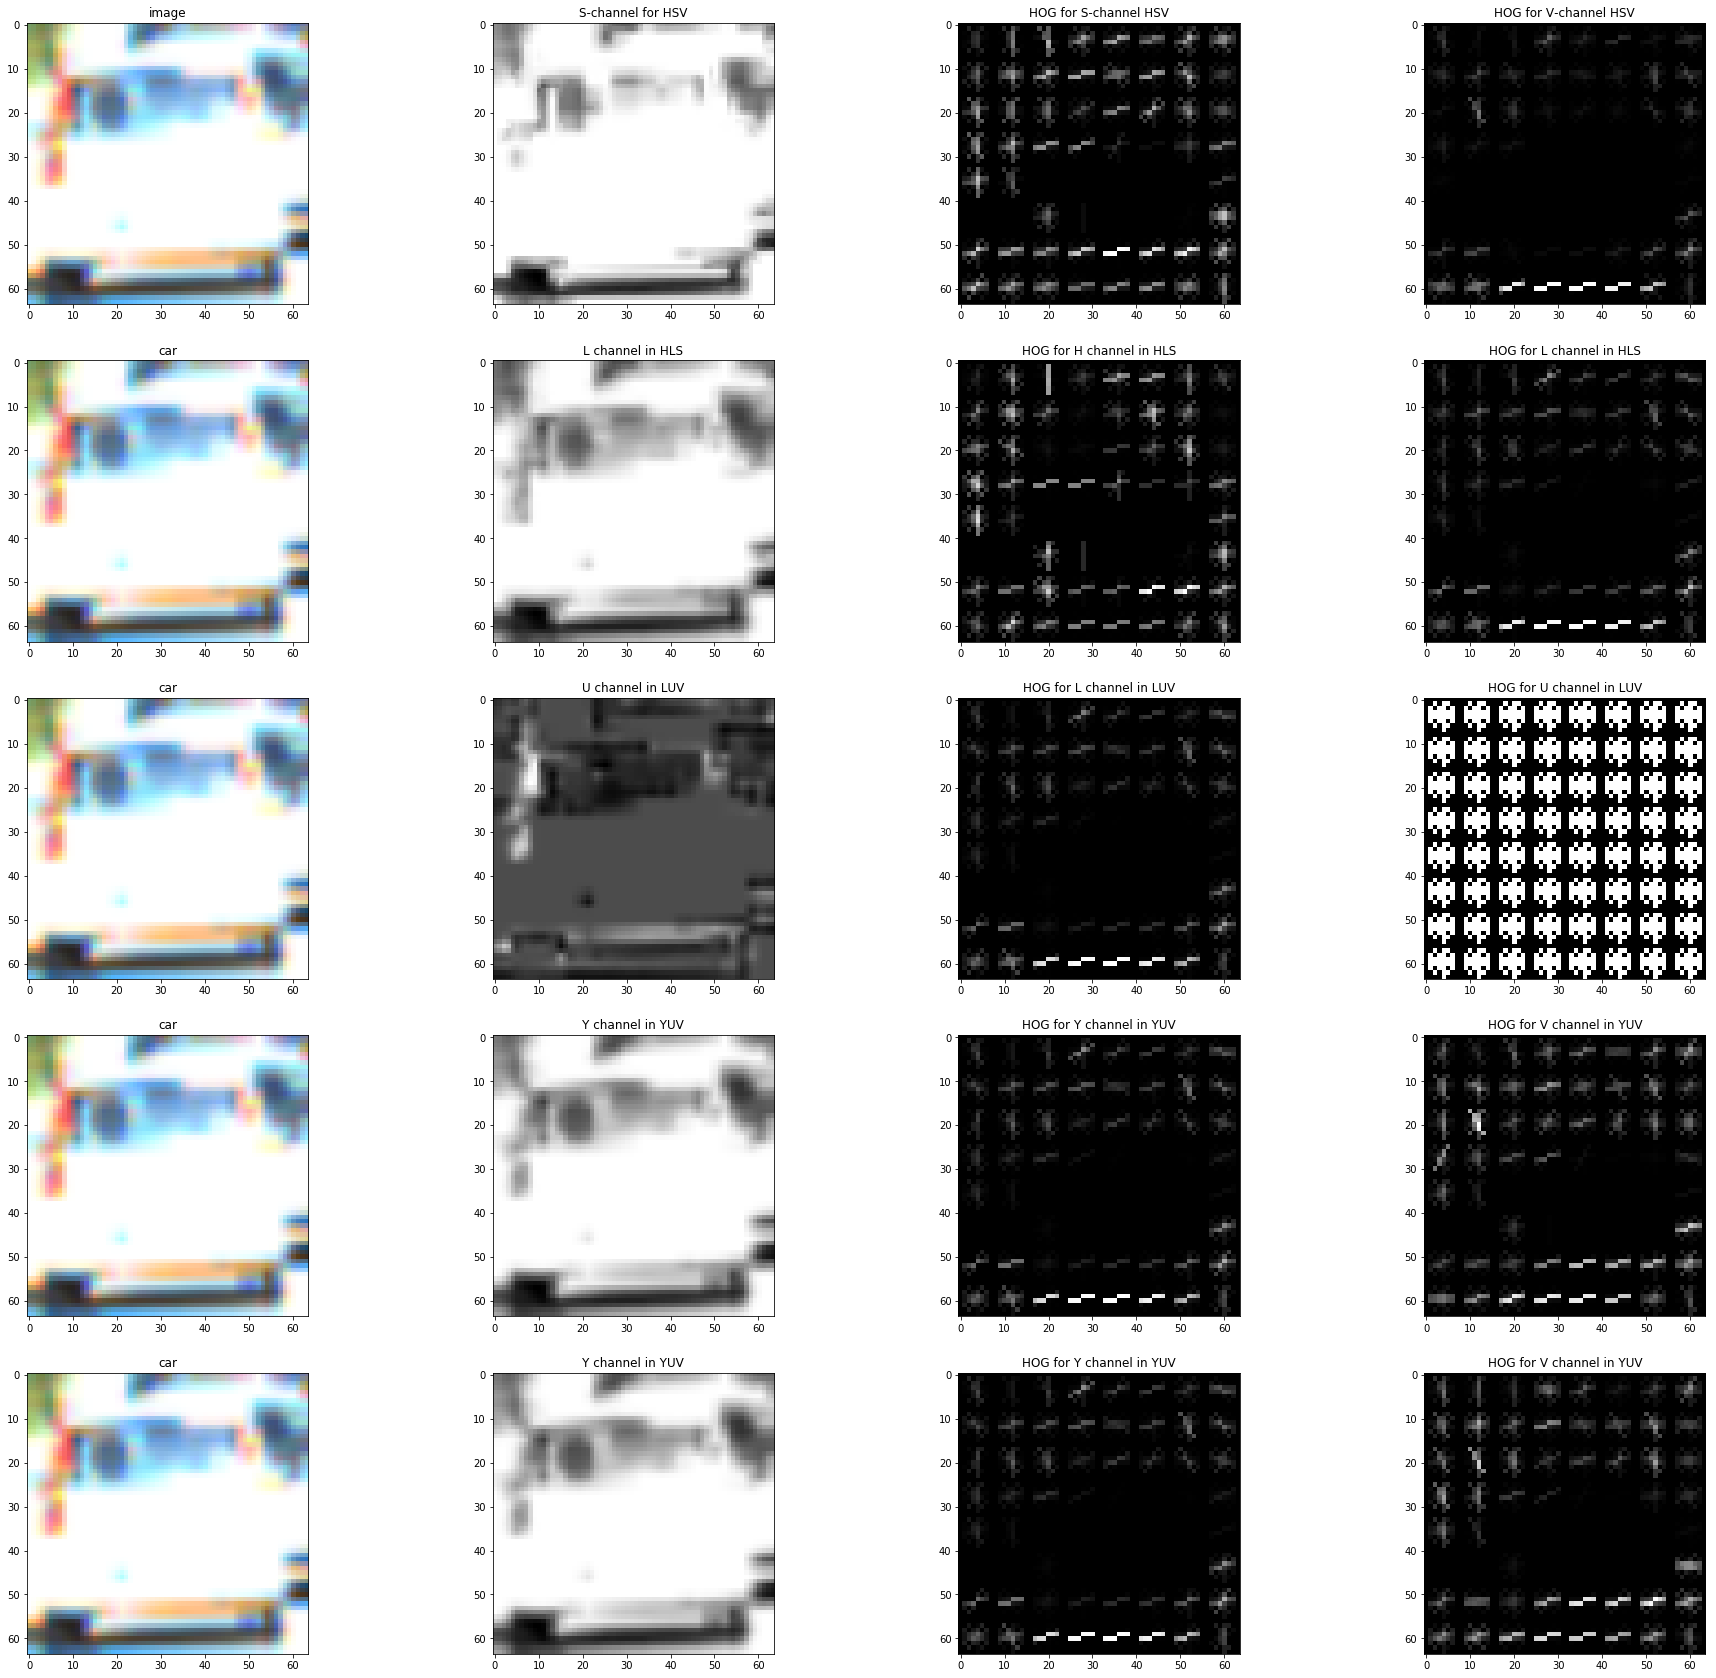

In [27]:
rand_carnot = np.random.randint(0, len(notcarsfiles))
rand_caryes = np.random.randint(0, len(carsfiles))

# orientation
o = 9
# pix per cell
ppc = 8
# cell per block
cpb = 2

example_car_1 = mpimg.imread(carsfiles[rand_caryes])
example_not_1 = mpimg.imread(notcarsfiles[rand_carnot])

image_1_1 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2HSV)
image_1_2 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2HLS)
image_1_3 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2LUV)
image_1_4 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2YUV)
image_1_5 = cv2.cvtColor(example_car_1, cv2.COLOR_RGB2YCrCb)

_, hog_image_1_1_0 = get_hog_features(image_1_1[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_1_1 = get_hog_features(image_1_1[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_1_2 = get_hog_features(image_1_1[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)

_, hog_image_1_2_0 = get_hog_features(image_1_2[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_2_1 = get_hog_features(image_1_2[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_2_2 = get_hog_features(image_1_2[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)

_, hog_image_1_3_0 = get_hog_features(image_1_3[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_3_1 = get_hog_features(image_1_3[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_3_2 = get_hog_features(image_1_3[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)

_, hog_image_1_4_0 = get_hog_features(image_1_4[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_4_1 = get_hog_features(image_1_4[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_4_2 = get_hog_features(image_1_4[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)

_, hog_image_1_5_0 = get_hog_features(image_1_5[:, :, 0], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_5_1 = get_hog_features(image_1_5[:, :, 1], o, ppc, cpb, vis=True, feature_vec=False)
_, hog_image_1_5_2 = get_hog_features(image_1_5[:, :, 2], o, ppc, cpb, vis=True, feature_vec=False)



plt.figure(figsize=(32, 30))
#plt.axes('off')
plt.subplot(5, 4, 1)
plt.imshow(example_car_1)
plt.title('image')
plt.subplot(5, 4, 2)
plt.imshow(image_1_1[:, :, 2], cmap='gray')
plt.title('S-channel for HSV')
plt.subplot(5, 4, 3)
plt.imshow(hog_image_1_1_1, cmap='gray')
plt.title('HOG for S-channel HSV')
plt.subplot(5, 4, 4)
plt.imshow(hog_image_1_1_2, cmap='gray')
plt.title('HOG for V-channel HSV')


plt.subplot(5, 4, 5)
plt.imshow(example_car_1, cmap='gray')
plt.title('car')
plt.subplot(5, 4, 6)
plt.imshow(image_1_2[:, :, 1], cmap='gray')
plt.title('L channel in HLS')
plt.subplot(5, 4, 7)
plt.imshow(hog_image_1_2_0, cmap='gray')
plt.title('HOG for H channel in HLS')
plt.subplot(5, 4, 8)
plt.imshow(hog_image_1_2_1, cmap='gray')
plt.title('HOG for L channel in HLS')


plt.subplot(5, 4, 9)
plt.imshow(example_car_1, cmap='gray')
plt.title('car')
plt.subplot(5, 4, 10)
plt.imshow(image_1_3[:, :, 1], cmap='gray')
plt.title('U channel in LUV')
plt.subplot(5, 4, 11)
plt.imshow(hog_image_1_3_0, cmap='gray')
plt.title('HOG for L channel in LUV')
plt.subplot(5, 4, 12)
plt.imshow(hog_image_1_3_1, cmap='gray')
plt.title('HOG for U channel in LUV')

plt.subplot(5, 4, 13)
plt.imshow(example_car_1, cmap='gray')
plt.title('car')
plt.subplot(5, 4, 14)
plt.imshow(image_1_4[:, :, 0], cmap='gray')
plt.title('Y channel in YUV')
plt.subplot(5, 4, 15)
plt.imshow(hog_image_1_4_0, cmap='gray')
plt.title('HOG for Y channel in YUV')
plt.subplot(5, 4, 16)
plt.imshow(hog_image_1_4_2, cmap='gray')
plt.title('HOG for V channel in YUV')


plt.subplot(5, 4, 17)
plt.imshow(example_car_1, cmap='gray')
plt.title('car')
plt.subplot(5, 4, 18)
plt.imshow(image_1_5[:, :, 0], cmap='gray')
plt.title('Y channel in YCrCb')
plt.subplot(5, 4, 19)
plt.imshow(hog_image_1_5_0, cmap='gray')
plt.title('HOG for Y channel in YCrCb')
plt.subplot(5, 4, 20)
plt.imshow(hog_image_1_5_2, cmap='gray')
plt.title('HOG for Cb channel in YCrCb')


In [31]:
# orientation
o = 9
# pix per cell
ppc = 8
# cell per block
cpb = 2
# color space
#cs = 'YUV'
#cs = 'LUV'
cs = 'YCrCb'
# HOG channels
#hogc = '0'
hogc = 'ALL'
# spatial size
ss = (16, 16)
#ss = (32, 32)
# histogram bins
nhb = 32

# y-region to seach
y_start_stop = [None, None]

# reduce time during experimentation (total=8968)
sample_size = 8968
sample_size = 5000

print('')
print('Extracting features ... (duration ~ {:>7.1f}s)'.format(sample_size*0.005*2))

t = time.time()

car_features = extract_train_features(carlist[:sample_size], 
                                      cspace=cs,
                                      spatial_size=ss,
                                      hist_bins=nhb, 
                                      orient=o, 
                                      pix_per_cell=ppc,
                                      cell_per_block=cpb, 
                                      hog_channel=hogc)

notcar_features = extract_train_features(notcarlist[:sample_size], 
                                         cspace=cs,
                                         spatial_size=ss,
                                         hist_bins=nhb, 
                                         orient=o, 
                                         pix_per_cell=ppc,
                                         cell_per_block=cpb, 
                                         hog_channel=hogc)

t2 = time.time()
print('Time to extract features: {:5.1f}s, {:8.5f}s/img'.format((t2 - t), (t2 - t)/(sample_size*2)))
print('')

print('car    ', np.array(car_features).shape)
print('not car', np.array(notcar_features).shape)
print('')

# scaler works better in 64bit
X = np.concatenate((car_features, notcar_features), axis=0).astype(np.float64)  

# labels
y = np.concatenate((np.ones((len(car_features), 1)), np.zeros((len(notcar_features), 1))), axis=0).ravel()

print('X', X.shape, X.dtype)
print('y', y.shape, y.dtype)
print('')


Extracting features ... (duration ~    50.0s)
Time to extract features:  54.4s,  0.00544s/img

car     (5000, 6156)
not car (5000, 6156)

X (10000, 6156) float64
y (10000,) float64



In [32]:
print('='*40)
print('Model training')
print('='*40)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

#scaled_X, y = shuffle(scaled_X, y)

# split data set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# shuffle data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

print('Training set:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('')
print('Testing set:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print('')

# create model object
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()

# =======================
# Fit model
# =======================
svc.fit(X_train, y_train)

t2 = time.time()
print('Time to train SVC: {:5.3f}s'.format((t2 - t)))
      
# Check the score of the SVC
print('Test Accuracy of SVC: {:6.4f}'.format(svc.score(X_test, y_test)))

print('Number of features: ', car_features[0].shape[0])

#plt.figure(figsize=(20, 10))
#plt.subplot(131)
#plt.plot(car_features[0][:768])
#plt.subplot(132)
#plt.plot(car_features[0][768:768+96])
#plt.subplot(133)
#plt.plot(car_features[0][768+96:])

#pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)

Model training
Training set:
X_train: (8000, 6156)
y_train: (8000,)

Testing set:
X_test: (2000, 6156)
y_test: (2000,)

Time to train SVC: 3.055s
Test Accuracy of SVC: 0.9815
Number of features:  6156


In [33]:
# Ref.: https://docs.python.org/3/library/pickle.html

data = {
    'svc': svc,
    'X_scaler': X_scaler,

    #'scaled_X': scaled_X,
    #'X': X,
    #'y': y,
    #'X_train': X_train,
    #'X_test': X_test, 
    #'y_train': y_train, 
    #'y_test': y_test,
    
    'o': o,
    'cpb': cpb,
    'cs': cs,
    'hogc': hogc,
    'nhb': nhb,
    'ppc': ppc,
    'ss': ss,
}

with open('model.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# 
# open().write() in OSX has trouble writing files over 2GB
# data.pickle = 1.2 GB
# 

data = {
    'car_features': car_features,
    'notcar_features': notcar_features,
}

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [34]:

# Load data from the pickle file
with open('model.pickle', 'rb') as f:
    model_data = pickle.load(f)
    svc = model_data['svc']
    X_scaler = model_data['X_scaler']
    cs = model_data['cs']


Features not normalized


Text(0.5,0,'features')

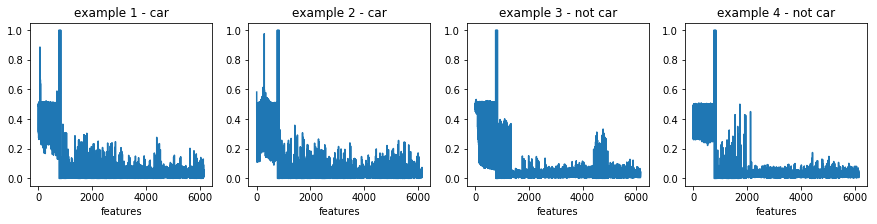

In [35]:
print('Features not normalized')

plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.plot(car_features[0])
plt.title('example 1 - car')
plt.xlabel('features')

plt.subplot(142)
plt.plot(car_features[1])
plt.title('example 2 - car')
plt.xlabel('features')

plt.subplot(143)
plt.plot(notcar_features[0])
plt.title('example 3 - not car')
plt.xlabel('features')

plt.subplot(144)
plt.plot(notcar_features[1])
plt.title('example 4 - not car')
plt.xlabel('features')

In [36]:
img_test_list = glob.glob('test_images/*.jpg')

ex1 = mpimg.imread(img_test_list[0])
print('image shape', ex1.shape)
#ystart = np.int(ex1.shape[0] * 0.55)
#ystop  = np.int(ex1.shape[0] * 0.92)
ystart = 400
ystop = 656
scale = 1.5

print('search region in y:', ystart, ystop)

image shape (720, 1280, 3)
search region in y: 400 656


image 1 test_images/test1.jpg
Find cars: image    1
  pix_per_cell 8
  cell_per_block 2
  cells_per_step 2
  nxblocks 105
  nyblocks 20
  nxsteps 49
  nysteps 6
  nblocks_per_window 7
  scale 1.5
  window 64
  cells_per_step 2
  shape (170, 853, 3)
  spatial_size (16, 16)
  histbins 32
 found car 528 0
 found car 544 0
 found car 560 0
 found car 576 0
 found car 688 0
 found car 704 0
 found car 752 16
 found car 768 16
  features (1, 6156)
[((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520))]


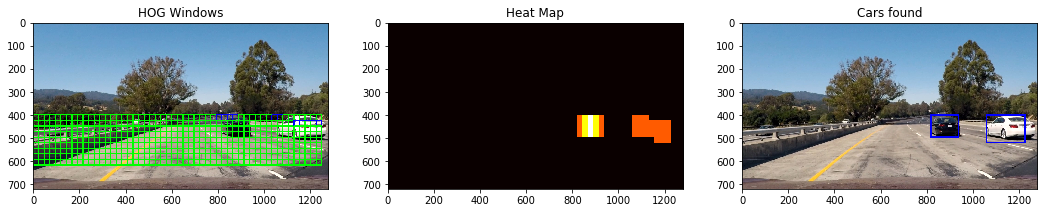

In [39]:
i = 0
#for img_file in img_test_list:
for img_file in ['test_images/test1.jpg']:
    i += 1
    
    print('image', i, img_file)
    
    # read
    img = mpimg.imread(img_file)
    
    # search and find!
    ok = True
    try:
        out_img, all_box, box_list = find_cars(img, 
                                              i,
                                              cs,
                                              ystart, 
                                              ystop, 
                                              scale, 
                                              svc, 
                                              X_scaler, 
                                              o, 
                                              ppc, 
                                              cpb, 
                                              2,
                                              ss, 
                                              64,
                                              32)

    except NameError as e:
        print('trouble in image', i)
        ok = False
        print(e)
        continue
    
    print(box_list)
    
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_boxes(np.copy(img), labels)
    
    #draw_emphasis(out_img, box_list, color=(0, 0, 255), thick=6, form='box')
    
    plt.figure(figsize=(18,8))
    
    plt.subplot(131)
    plt.imshow(out_img)
    plt.title('HOG Windows')
    #plt.axes('off')
    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
    plt.subplot(133)
    plt.imshow(draw_img)
    plt.title('Cars found')

# Process Video